In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from os.path import join as oj
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.append('../src')
import numpy as np
import data_pecarn, data_psrc
from validate import calc_stats
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import itertools

DATASET = 'PSRC'

if DATASET == 'PECARN':
    d = data_pecarn.get_data(use_processed=True, dummy=True, frac_missing_allowed=1, impute_feats=False)
    iaii = d['iai_intervention']
    iai = d['iai']
    fast_study_cohort, fast_abnormal = data_pecarn.get_FAST(d)    
else:
    d = data_psrc.get_data(use_processed=False, dummy=True) #use_processed_feats=True,)
    iaii = d['iai_intervention']
    iai = d['iai']
    d['FAST (choice=not performed)'] = d['FAST (choice=0t performed)']
    fast_study_cohort, fast_abnormal = data_psrc.get_FAST(d)    

In [2]:
# print('fast options', [k for k in d.keys() if k.lower().startswith('fast')])

In [3]:
combs = []
if DATASET == 'PSRC':
    rules = {
        'Abdominal wall trauma or seatbelt sign': d['AbdTrauma_or_SeatBeltSign_yes']==1,
        'GCSScore < 14': d['GCSScore'] < 14,
        'Abdominal tenderness': d['AbdTenderDegree_None'] == 0,
        'FAST': fast_abnormal,
    }
else:
    rules = {
        'Abdominal wall trauma or seatbelt sign': d['AbdTrauma_or_SeatBeltSign_yes']==1,
        'GCSScore < 14': d['GCSScore'] < 14,
        'Abdominal tenderness': d['AbdTenderDegree_unknown'] == 0,
        'FAST': fast_abnormal,
    }
ks = list(rules.keys())
for r in range(len(ks)):
    combs += list(itertools.combinations(ks, r=r + 1))
combs


[('Abdominal wall trauma or seatbelt sign',),
 ('GCSScore < 14',),
 ('Abdominal tenderness',),
 ('FAST',),
 ('Abdominal wall trauma or seatbelt sign', 'GCSScore < 14'),
 ('Abdominal wall trauma or seatbelt sign', 'Abdominal tenderness'),
 ('Abdominal wall trauma or seatbelt sign', 'FAST'),
 ('GCSScore < 14', 'Abdominal tenderness'),
 ('GCSScore < 14', 'FAST'),
 ('Abdominal tenderness', 'FAST'),
 ('Abdominal wall trauma or seatbelt sign',
  'GCSScore < 14',
  'Abdominal tenderness'),
 ('Abdominal wall trauma or seatbelt sign', 'GCSScore < 14', 'FAST'),
 ('Abdominal wall trauma or seatbelt sign', 'Abdominal tenderness', 'FAST'),
 ('GCSScore < 14', 'Abdominal tenderness', 'FAST'),
 ('Abdominal wall trauma or seatbelt sign',
  'GCSScore < 14',
  'Abdominal tenderness',
  'FAST')]

In [4]:

def get_pecarn_preds(d):
    pecarn_cdr = {
        'Abdominal wall trauma or seatbelt sign': d['AbdTrauma_or_SeatBeltSign_yes'] == 1,
        'GCSScore < 14': d['GCSScore'] < 14,
        'Abdominal tenderness': d['AbdTenderDegree_None'] == 0,
        'FAST': fast_abnormal,
        'ThoracicTrauma': d['ThoracicTrauma_yes'] == 1,
        'AbdomenPain': d['AbdomenPain_yes'] == 1,
        'DecrBreathSound': d['DecrBreathSound_yes'] == 1,
        'VomitWretch': d['VomitWretch_yes'] == 1,
    }
    preds = np.zeros(d.shape[0])
    for k in pecarn_cdr.keys():
        preds = preds | pecarn_cdr[k]
    return preds

In [25]:
outcome = iaii
r = defaultdict(list)
for comb in combs + ['pecarn_cdr']:
    preds = np.zeros_like(outcome)
    if comb == 'pecarn_cdr':
        preds = get_pecarn_preds(d)
    else:
        for k in comb:
            preds = preds | rules[k]
    tn, fp, fn, tp, sens, spec = calc_stats(outcome[fast_study_cohort],
                                            preds[fast_study_cohort])
    r['sens'].append(sens)
    r['spec'].append(spec)
    r['rules'].append(comb)
    r['fast'].append('FAST' in comb)
    r['fp'].append(fp)
    r['fn'].append(fn)
    r['tp'].append(tp)
    r['tn'].append(tn)
    sens_se = np.sqrt(sens * (1 - sens) / (tp + fn))
    spec_se = np.sqrt(spec * (1 - spec) / (tn + fp))
    r['sens_se'].append(sens_se)
    r['spec_se'].append(spec_se)
    r['sens_ci'].append(1.96 * sens_se)
    r['spec_ci'].append(1.96 * spec_se)

r = pd.DataFrame.from_dict(r).round(3)
r['spec_int'] = (r['spec'] - r['spec_ci']).round(3).astype(str) + ' ' + (r['spec'] + r['spec_ci']).round(3).astype(str)
r['sens_int'] = (r['sens'] - r['sens_ci']).round(3).astype(str) + ' ' + (r['sens'] + r['sens_ci']).round(3).astype(str)

In [24]:
pd.set_option('display.max_colwidth', None)
r.round(3).sort_values(by=['sens', 'spec'], ascending=False)
# can get 95% CI with 

,sens,spec,rules,fast,fp,fn,tp,tn,sens_se,spec_se,sens_ci,spec_ci,spec_int
13,0.963,0.632,"(GCSScore < 14, Abdominal tenderness, FAST)",True,295,1,26,507,0.036,0.017,0.071,0.033,0.599 0.665
11,0.963,0.625,"(Abdominal wall trauma or seatbelt sign, GCSScore < 14, FAST)",True,301,1,26,501,0.036,0.017,0.071,0.034,0.591 0.659
5,0.963,0.617,"(Abdominal wall trauma or seatbelt sign, Abdominal tenderness)",False,307,1,26,495,0.036,0.017,0.071,0.034,0.583 0.651
12,0.963,0.591,"(Abdominal wall trauma or seatbelt sign, Abdominal tenderness, FAST)",True,328,1,26,474,0.036,0.017,0.071,0.034,0.5569999999999999 0.625
10,0.963,0.564,"(Abdominal wall trauma or seatbelt sign, GCSScore < 14, Abdominal tenderness)",False,350,1,26,452,0.036,0.018,0.071,0.034,0.5299999999999999 0.598
14,0.963,0.542,"(Abdominal wall trauma or seatbelt sign, GCSScore < 14, Abdominal tenderness, FAST)",True,367,1,26,435,0.036,0.018,0.071,0.034,0.508 0.5760000000000001
15,0.963,0.435,pecarn_cdr,False,453,1,26,349,0.036,0.018,0.071,0.034,0.401 0.469
9,0.926,0.685,"(Abdominal tenderness, FAST)",True,253,2,25,549,0.050,0.016,0.099,0.032,0.653 0.7170000000000001
7,0.926,0.657,"(GCSScore < 14, Abdominal tenderness)",False,275,2,25,527,0.050,0.017,0.099,0.033,0.624 0.6900000000000001
4,0.926,0.655,"(Abdominal wall trauma or seatbelt sign, GCSScore < 14)",False,277,2,25,525,0.050,0.017,0.099,0.033,0.622 0.6880000000000001


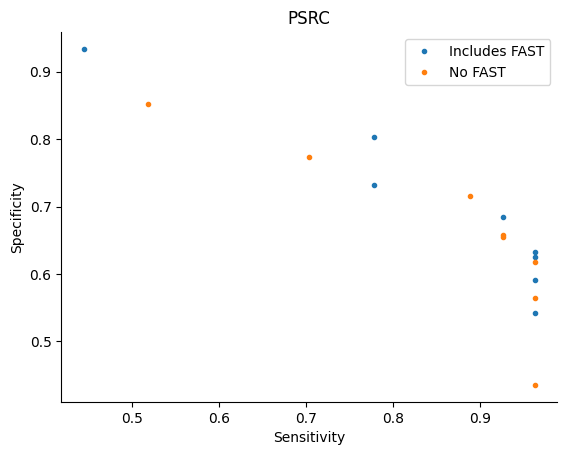

In [13]:
plt.title(DATASET)
plt.plot(r['sens'][r['fast']], r['spec'][r['fast']], '.', label='Includes FAST')
plt.plot(r['sens'][~r['fast']], r['spec'][~r['fast']], '.', label='No FAST')
plt.xlabel('Sensitivity')
plt.ylabel('Specificity')
plt.legend()
plt.show()